# SpaceTime Matrix demo on Spider HPC

This notebook demonstrates `stm` on Spider. It uses [JupyterDaskOnSLURM](https://github.com/RS-DAT/JupyterDaskOnSLURM) to scale up. 

### Data used for this notebook
- Interferogram stack: `/project/caroline/Share/stacks/nl_veenweiden_s1_asc_t088/`
- Polygons of NL crop pacels: `/project/caroline/Public/demo_sarxarray/data/brp/brpgewaspercelen_concept_2022_wgs84.gpkg`

### Setup environment
To setup the environment, please refer to the [user-guide](https://github.com/RS-DAT/JupyterDaskOnSLURM/blob/main/user-guide.md) of JupyterDaskOnSLURM. By following it, you setup a Python environment `jupyter_dask`. We assume the following setup are done inside `jupyter_dask`.

To execute this notebook, first clone the `stm` repostory to your local and install it with `demo` extra options

```sh
git clone git@github.com:MotionbyLearning/stm.git
cd stm
pip install .[demo]
```

You will also need `sarxarray` to load the interferogram stack as a start point. To install `sarxarray`, do:
```sh
cd ..
git clone git@github.com:MotionbyLearning/sarxarray.git
cd sarxarray
pip install .
```

After installation, you can refer to the [user-guide](https://github.com/RS-DAT/JupyterDaskOnSLURM/blob/main/user-guide.md) again on how to access this Notebook on HPC to your local.

### Load a SLC stack using SarXarray

In [1]:
import numpy as np
from pathlib import Path
import sarxarray

In [2]:
# SLC stack processed by Doris V5
path = Path('/project/caroline/Share/stacks/nl_veenweiden_s1_asc_t088/stack')

# Make a list of SLCs to read
f_slc = 'cint_srd.raw'
list_slcs = [p/f_slc for p in path.rglob(('[0-9]' * 8)) if not p.match('20200325')]
list_slcs = list_slcs[0:50] # 100 images for example

# Geo referenced coordinates
f_lat = [path/'20210730'/'phi.raw']
f_lon = [path/'20210730'/'lam.raw']

# Metadata of the stack
shape=(10018, 68656)
dtype = np.dtype([('re', np.float32), ('im', np.float32)])

In [3]:
# Load complex data
stack = sarxarray.from_binary(list_slcs, shape, dtype=dtype)

# Load coordinates
lat = sarxarray.from_binary(f_lat, shape, vlabel="lat", dtype=np.float32)
lon = sarxarray.from_binary(f_lon, shape, vlabel="lon", dtype=np.float32)
stack = stack.assign_coords(lat = (("azimuth", "range"), lat.squeeze().lat.data), lon = (("azimuth", "range"), lon.squeeze().lon.data))
stack

<xarray.Dataset>
Dimensions:    (azimuth: 10018, range: 68656, time: 50)
Coordinates:
  * azimuth    (azimuth) int64 0 1 2 3 4 5 ... 10013 10014 10015 10016 10017
  * range      (range) int64 0 1 2 3 4 5 ... 68650 68651 68652 68653 68654 68655
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    lat        (azimuth, range) float32 dask.array<chunksize=(6000, 5000), meta=np.ndarray>
    lon        (azimuth, range) float32 dask.array<chunksize=(6000, 5000), meta=np.ndarray>
Data variables:
    complex    (azimuth, range, time) complex64 dask.array<chunksize=(4000, 4000, 1), meta=np.ndarray>
    amplitude  (azimuth, range, time) float32 dask.array<chunksize=(4000, 4000, 1), meta=np.ndarray>
    phase      (azimuth, range, time) float32 dask.array<chunksize=(4000, 4000, 1), meta=np.ndarray>

### Select a subset

In [4]:
stack_subset = stack.sel(azimuth=range(30_00,60_00), range=range(175_00,205_00))
stack_subset

<xarray.Dataset>
Dimensions:    (azimuth: 3000, range: 3000, time: 50)
Coordinates:
  * azimuth    (azimuth) int64 3000 3001 3002 3003 3004 ... 5996 5997 5998 5999
  * range      (range) int64 17500 17501 17502 17503 ... 20496 20497 20498 20499
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    lat        (azimuth, range) float32 dask.array<chunksize=(3000, 2500), meta=np.ndarray>
    lon        (azimuth, range) float32 dask.array<chunksize=(3000, 2500), meta=np.ndarray>
Data variables:
    complex    (azimuth, range, time) complex64 dask.array<chunksize=(1000, 2500, 1), meta=np.ndarray>
    amplitude  (azimuth, range, time) float32 dask.array<chunksize=(1000, 2500, 1), meta=np.ndarray>
    phase      (azimuth, range, time) float32 dask.array<chunksize=(1000, 2500, 1), meta=np.ndarray>

In [5]:
mrm = stack_subset.slcstack.mrm()

--- Initiate a Dask cluster here ---

--- you can use the Dask icon on the left of the Jupyter environment ---

--- In this demo we init a cluster with 12 workers ---

In [6]:
from dask.distributed import Client

client = Client("tcp://10.0.0.146:36039")
client

<Client: 'tcp://10.0.0.146:36039' processes=12 threads=48, memory=192.00 GiB>

In [7]:
mrm = mrm.compute()

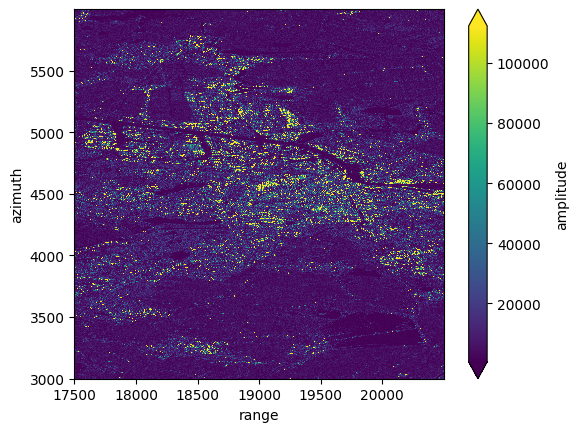

In [8]:
# Visualize
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.imshow(mrm)
mrm.plot(robust=True, ax=ax)

### Export to a Space Time Matrix

In [9]:
stm = stack_subset.slcstack.point_selection(threshold=2, method="amplitude_dispersion",chunks=100_000)
stm

<xarray.Dataset>
Dimensions:    (time: 50, points: 2370654)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    lat        (points) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    lon        (points) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
  * points     (points) int64 0 1 2 3 4 ... 2370650 2370651 2370652 2370653
    azimuth    (points) int64 dask.array<chunksize=(100000,), meta=np.ndarray>
    range      (points) int64 dask.array<chunksize=(100000,), meta=np.ndarray>
Data variables:
    complex    (points, time) complex64 dask.array<chunksize=(100000, 50), meta=np.ndarray>
    amplitude  (points, time) float32 dask.array<chunksize=(100000, 50), meta=np.ndarray>
    phase      (points, time) float32 dask.array<chunksize=(100000, 50), meta=np.ndarray>

In [10]:
# Export to Zarr
stm.to_zarr("stm.zarr", mode="w") # overwrite for demo

### Loading SpaceTime Matrix from Zarr

In [11]:
import xarray as xr
path_stm = Path('./stm.zarr')
stm_demo = xr.open_zarr(path_stm)
stm_demo

<xarray.Dataset>
Dimensions:    (points: 2370654, time: 50)
Coordinates:
    azimuth    (points) int64 dask.array<chunksize=(100000,), meta=np.ndarray>
    lat        (points) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
    lon        (points) float32 dask.array<chunksize=(100000,), meta=np.ndarray>
  * points     (points) int64 0 1 2 3 4 ... 2370650 2370651 2370652 2370653
    range      (points) int64 dask.array<chunksize=(100000,), meta=np.ndarray>
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Data variables:
    amplitude  (points, time) float32 dask.array<chunksize=(100000, 50), meta=np.ndarray>
    complex    (points, time) complex64 dask.array<chunksize=(100000, 50), meta=np.ndarray>
    phase      (points, time) float32 dask.array<chunksize=(100000, 50), meta=np.ndarray>

In [12]:
stm_demo = stm_demo.chunk({"points": 200_000, "time":-1})
stm_demo

<xarray.Dataset>
Dimensions:    (points: 2370654, time: 50)
Coordinates:
    azimuth    (points) int64 dask.array<chunksize=(200000,), meta=np.ndarray>
    lat        (points) float32 dask.array<chunksize=(200000,), meta=np.ndarray>
    lon        (points) float32 dask.array<chunksize=(200000,), meta=np.ndarray>
  * points     (points) int64 0 1 2 3 4 ... 2370650 2370651 2370652 2370653
    range      (points) int64 dask.array<chunksize=(200000,), meta=np.ndarray>
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Data variables:
    amplitude  (points, time) float32 dask.array<chunksize=(200000, 50), meta=np.ndarray>
    complex    (points, time) complex64 dask.array<chunksize=(200000, 50), meta=np.ndarray>
    phase      (points, time) float32 dask.array<chunksize=(200000, 50), meta=np.ndarray>

### STM enrichment from Polygon file

In [13]:
# Path to the BRP polygon of NL
# Need a abs path for cluster processing
path_polygon = Path('/project/caroline/Public/demo_sarxarray/data/brp/brpgewaspercelen_concept_2022_wgs84.gpkg')

In [14]:
import geopandas as gpd
# Read one row and check columns
polygons_one_row = gpd.read_file(path_polygon, rows=1)
polygons_one_row

,category,gewas,gewascode,jaar,status,geometry
0,Bouwland,"Tarwe, winter-",233,2022,Concept,"POLYGON ((5.55271 52.50400, 5.55311 52.50411, ..."


In [15]:
import stm

# Data enrichment
fields_to_query = ['gewas', 'category']

# When AoI is small and less number of chunks: directly feed in the polygon file. Multi-process can be blocked by file IO
stm_demo = stm_demo.stm.enrich_from_polygon(path_polygon, fields_to_query)

# # When AoI is big and large number of chunks: First load in the polygons
# xmin, ymin, xmax, ymax = [
#         stm_demo['lon'].data.min().compute(),
#         stm_demo['lat'].data.min().compute(),
#         stm_demo['lon'].data.max().compute(),
#         stm_demo['lat'].data.max().compute(),
#     ]
# polygons = gpd.read_file(path_polygon, bbox=(xmin, ymin, xmax, ymax))
# stm_demo = stm_demo.stm.enrich_from_polygon(polygons, fields_to_query)

In [16]:
stm_demo

<xarray.Dataset>
Dimensions:    (points: 2370654, time: 50)
Coordinates:
  * points     (points) int64 0 1 2 3 4 ... 2370650 2370651 2370652 2370653
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    azimuth    (points) int64 dask.array<chunksize=(200000,), meta=np.ndarray>
    lat        (points) float32 dask.array<chunksize=(200000,), meta=np.ndarray>
    lon        (points) float32 dask.array<chunksize=(200000,), meta=np.ndarray>
    range      (points) int64 dask.array<chunksize=(200000,), meta=np.ndarray>
Data variables:
    amplitude  (points, time) float32 dask.array<chunksize=(200000, 50), meta=np.ndarray>
    complex    (points, time) complex64 dask.array<chunksize=(200000, 50), meta=np.ndarray>
    phase      (points, time) float32 dask.array<chunksize=(200000, 50), meta=np.ndarray>
    gewas      (points) object dask.array<chunksize=(200000,), meta=np.ndarray>
    category   (points) object dask.array<chunksize=(200000,), meta=np.ndarray>

### Subset by Polygons

In [17]:
stm_demo_subset = stm_demo.stm.subset(method='polygon', polygon=path_polygon)
stm_demo_subset

/home/caroline-oku/miniconda3/envs/jupyter_dask/lib/python3.11/site-packages/distributed/worker.py:2988: UserWarning: Large object of size 1.53 MiB detected in task graph: 
  ([('points',), <xarray.IndexVariable 'points' (poi ... 799999]), {}],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


<xarray.Dataset>
Dimensions:    (points: 510097, time: 50)
Coordinates:
  * points     (points) int64 9 11 12 13 14 ... 2370650 2370651 2370652 2370653
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    azimuth    (points) int64 dask.array<chunksize=(200000,), meta=np.ndarray>
    lat        (points) float32 dask.array<chunksize=(200000,), meta=np.ndarray>
    lon        (points) float32 dask.array<chunksize=(200000,), meta=np.ndarray>
    range      (points) int64 dask.array<chunksize=(200000,), meta=np.ndarray>
Data variables:
    amplitude  (points, time) float32 dask.array<chunksize=(200000, 50), meta=np.ndarray>
    complex    (points, time) complex64 dask.array<chunksize=(200000, 50), meta=np.ndarray>
    phase      (points, time) float32 dask.array<chunksize=(200000, 50), meta=np.ndarray>
    gewas      (points) object dask.array<chunksize=(200000,), meta=np.ndarray>
    category   (points) object dask.array<chunksize=(200000,), meta=np.ndarray>

### Visualize the points

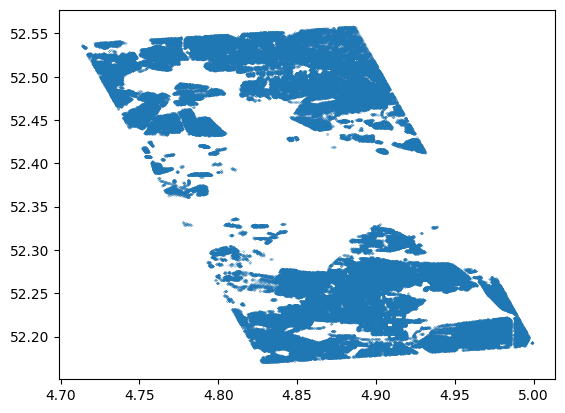

In [18]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
plt.scatter(stm_demo_subset.lon.data, stm_demo_subset.lat.data, s=0.005)